In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment3

/home/pengyu.zhang/project/superres/ProbSR/Experiment3


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
from utils import *
import random
import torch.nn.functional as F

In [4]:
%cd Bicubic_Downsampling

/home/pengyu.zhang/project/superres/ProbSR/Experiment3/Bicubic_Downsampling


## Train Downscaling Network

### Model 1: Training $u_l=G(u_h)$

In [23]:
# Code downscaling matrix
N_low = 15
N_high = 60
scale = 4

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoch_num = 2000
batch_size = 8
lr = 0.01
gamma = 0.5

minimum_loss = float('inf')
loss_track = []

# Load training data
trainset = DataFromH5File5("/home/pengyu.zhang/project/superres/ProbSR/Experiment3/data/DownBy4_15_60_bicubic.h5",N_low,N_high,scale)
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

# Initialise training model
G = DownScale3D(1,16)
G.apply(weights_init_xavier).to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = lr, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=150, gamma=gamma)

# Logger info
dir_name = f'models/train_NN/model1/15_60/lr{lr}_gamma{gamma}'
makedir(dir_name)
logger = setup_logging('job0', dir_name, console=True)
logger.info(f'Training for {epoch_num} epoches and learning rate is {lr}')

for epoch in range(1, epoch_num+1):
    
    for i, d in enumerate(train_loader, 0):
        
        residual, high_res, low_res = d
        size = residual.shape[0]
        low_res = low_res.to(device).reshape(size,1,N_low,N_low,N_low)
        high_res = high_res.to(device).reshape(size,1,N_high,N_high,N_high)
        
        optG.zero_grad()
        out = G(high_res)
        loss = mse(low_res,out)/batch_size
        loss.backward()
        optG.step()
        
        if loss < minimum_loss:
            save_model(dir_name, epoch, 'best_model', r_scheduleG, G, optG)
            minimum_loss = loss
            
        if epoch%100 == 0:
            save_model(dir_name, epoch, 'model_epoch_{}'.format(epoch), r_scheduleG, G, optG)
            
        loss_track.append(loss.cpu().data.numpy())
        np.save(f'{dir_name}/chains/loss_curve.npy', np.array(loss_track))
        
        print("Epoch:", epoch, "Loss:", loss)

    r_scheduleG.step()

Output directory already exists
2024-08-22 17:17:07,752 : Training for 2000 epoches and learning rate is 0.01
Epoch: 1 Loss: tensor(5003.4189, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(725858.6250, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(106919.5000, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(310886.6875, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(175473.8594, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(932075.3750, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(12464.0996, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(22548.6797, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(2717803.2500, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(3990.2258, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(7810714., device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(2953178.2500, device='cuda:0', grad_fn=<

In [43]:
N_low = 15
N_high = 60
scale = 4
a, b, c, d = 1,1,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
z_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)
z_high = np.arange(0,1.0001,h_high)

In [26]:
w_low, r_low, A_low, x_low, y_low, z_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high, z_high = generate_data(N_high,a,b,c,d)

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = DownScale3D(1,16).to(device)
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment3/Bicubic_Downsampling/models/train_NN/model1/15_60/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [45]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)
out = G(w_high_tensor.reshape(1,N_high,N_high,N_high))

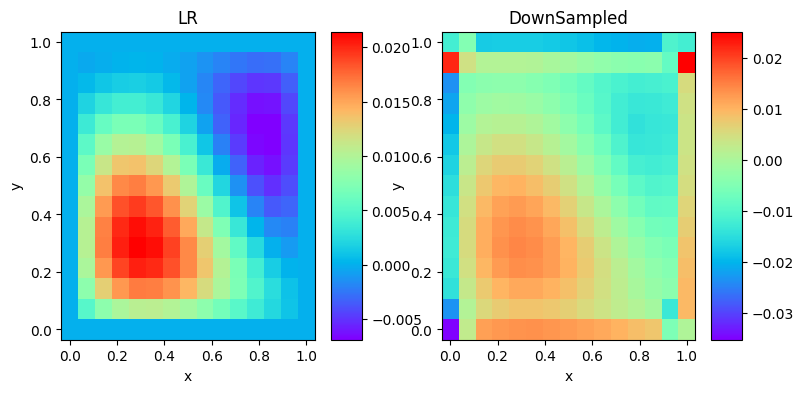

In [46]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, w_low_tensor.cpu().data.numpy()[3], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.03, 0.03)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, out.cpu().data.numpy()[0][3], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.006, 0.02)
plt.title('DownSampled')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Upscale by 4

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.0001
ll_sigma = 0.0005

In [48]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [49]:
G = DownScale3D(1,16).to(device)
# G.load_state_dict(torch.load('models/train_NN/model3/31_121/lr0.01_gamma0.1/ckpt/best_model.pth')['netG'])
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment3/Bicubic_Downsampling/models/train_NN/model1/15_60/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [50]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)

out = G(w_high_tensor.reshape(1,N_high,N_high,N_high)).reshape(N_low,N_low,N_low)

In [51]:
# Parameters for Langevin dynamics
K = 2500
s = 0.00001

x = torch.tensor(w_low).to(torch.float32).to(device)
z = F.interpolate(x.reshape(1,1,N_low,N_low,N_low),(N_high,N_high,N_high),mode='trilinear').reshape(N_high,N_high,N_high)
z = z.clone().detach().requires_grad_(True)
chains_evolution = []

for i in range(K):
    # Grad log-likelihood
    x_hat = G(z.reshape(1,N_high,N_high,N_high)).reshape(N_low,N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**3),(x-x_hat).reshape(N_low**3,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high**3,1)) - b_high.reshape(N_high**3,1)
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high,N_high]).to(device)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    
    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy()) 

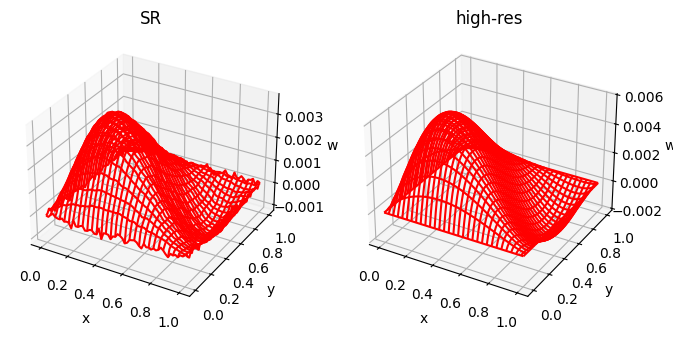

In [52]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy()[2],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high[2],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [53]:
error1 = abs(w_high - np.mean(chains_evolution,axis=0))
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 7.97083793076001e-05


### Model 2: Training $u_l=Hu_h+G(u_h)$

In [7]:
# Code downscaling matrix
N_low = 15
N_high = 60
scale = 4

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoch_num = 2000
batch_size = 8
lr = 0.01
gamma = 0.5

minimum_loss = float('inf')
loss_track = []

# Load training data
trainset = DataFromH5File5("/home/pengyu.zhang/project/superres/ProbSR/Experiment3/data/DownBy4_15_60_bicubic.h5",N_low,N_high,scale)
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

# Initialise training model
G = DownScale3D(1,16)
G.apply(weights_init_xavier).to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = lr, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=200, gamma=gamma)

# Logger info
dir_name = f'models/train_NN/model2/15_60/lr{lr}_gamma{gamma}'
makedir(dir_name)
logger = setup_logging('job0', dir_name, console=True)
logger.info(f'Training for {epoch_num} epoches and learning rate is {lr}')

for epoch in range(1, epoch_num+1):
    
    for i, d in enumerate(train_loader, 0):
        
        residual, high_res, low_res = d
        size = residual.shape[0]
        low_res = low_res.to(device).reshape(size,1,N_low,N_low,N_low)
        high_res = high_res.to(device).reshape(size,1,N_high,N_high,N_high)
        
        downscaled = F.interpolate(high_res.reshape(size,1,N_high,N_high,N_high),(N_low,N_low,N_low)).reshape(size,1,N_low,N_low,N_low)
        
        optG.zero_grad()
        out = downscaled + G(high_res)
        loss = mse(low_res,out)/batch_size
        loss.backward()
        optG.step()
        
        if loss < minimum_loss:
            save_model(dir_name, epoch, 'best_model', r_scheduleG, G, optG)
            minimum_loss = loss
            
        if epoch%100 == 0:
            save_model(dir_name, epoch, 'model_epoch_{}'.format(epoch), r_scheduleG, G, optG)
            
        loss_track.append(loss.cpu().data.numpy())
        np.save(f'{dir_name}/chains/loss_curve.npy', np.array(loss_track))
        
        print("Epoch:", epoch, "Loss:", loss)

    r_scheduleG.step()

Output directory already exists
2024-08-22 15:56:20,159 : Training for 2000 epoches and learning rate is 0.01


Epoch: 1 Loss: tensor(63.1971, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(46040.7109, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(14309.9238, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(11704272., device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(1085331., device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(6225827.5000, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(4539.1875, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(378439.6250, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(473944.2812, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(306401., device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(31954.6191, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(55334.1250, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(18314.2461, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(16997.175

In [12]:
N_low = 15
N_high = 60
scale = 4
a, b, c, d = 1,1,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
z_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)
z_high = np.arange(0,1.0001,h_high)

In [13]:
w_low, r_low, A_low, x_low, y_low, z_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high, z_high = generate_data(N_high,a,b,c,d)

/home/pengyu.zhang/project/superres/ProbSR/Experiment3/data_generation.py:131: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  w = linalg.spsolve(A,r).reshape((N,N,N))


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = DownScale3D(1,16).to(device)
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment3/Bicubic_Downsampling/models/train_NN/model2/15_60/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [15]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)
downscaled = F.interpolate(w_high_tensor.reshape(1,1,N_high,N_high,N_high),(N_low,N_low,N_low)).reshape(N_low,N_low,N_low)
out = G(w_high_tensor.reshape(1,N_high,N_high,N_high))
residual = w_low_tensor-downscaled

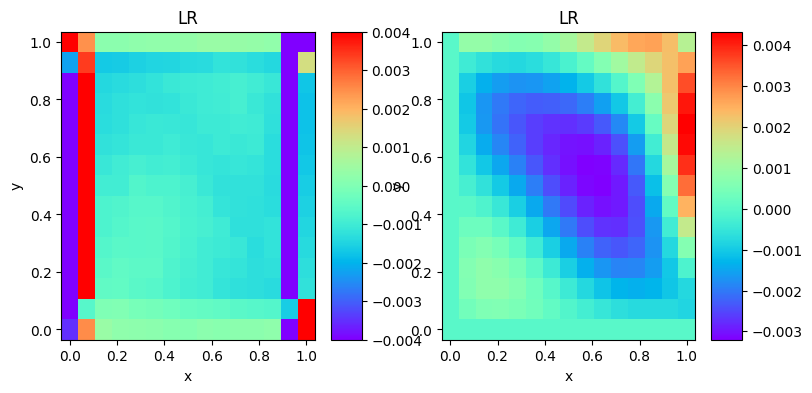

In [17]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, out.cpu().data.numpy()[0][4], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-0.004, 0.004)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, residual.cpu().data.numpy()[4], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.0001
ll_sigma = 0.0005

In [19]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [54]:
# Parameters for Langevin dynamics
K = 2500
s = 0.00001

chains_evolution = []
x = torch.tensor(w_low).to(torch.float32).to(device)
z = F.interpolate(x.reshape(1,1,N_low,N_low,N_low),(N_high,N_high,N_high),mode='trilinear').reshape(N_high,N_high,N_high)
z = z.clone().detach().requires_grad_(True)

for i in range(K):
    # Grad log-likelihood
    downscaled = F.interpolate(w_high_tensor.reshape(1,1,N_high,N_high,N_high),(N_low,N_low,N_low)).reshape(N_low,N_low,N_low)
    x_hat = downscaled + G(z.reshape(1,N_high,N_high,N_high)).reshape(N_low,N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**3),(x-x_hat).reshape(N_low**3,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]

    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high**3,1)) - b_high.reshape(N_high**3,1)
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high,N_high]).to(device)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    
    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy())   

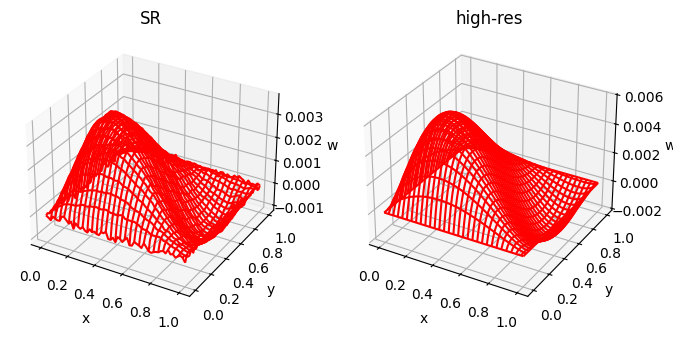

In [55]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy()[2],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high[2],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [56]:
error1 = abs(w_high - np.mean(chains_evolution,axis=0))
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 8.579015933998843e-05


### Model 3: Training $u_l = Hu_h + G(Hu_h)$

In [63]:
# Code downscaling matrix
N_low = 15
N_high = 60
scale = 4

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoch_num = 1000
batch_size = 8
lr = 0.01
gamma = 0.5

minimum_loss = float('inf')
loss_track = []

# Load training data
trainset = DataFromH5File5("/home/pengyu.zhang/project/superres/ProbSR/Experiment3/data/DownBy4_15_60_bicubic.h5",N_low,N_high,scale)
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

# Initialise training model
G = U_net(1,1)
G.apply(weights_init_xavier).to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = lr, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=100, gamma=gamma)

# Logger info
dir_name = f'models/train_NN/model_3/15_60/lr{lr}_gamma{gamma}'
makedir(dir_name)
logger = setup_logging('job0', dir_name, console=True)
logger.info(f'Training for {epoch_num} epoches and learning rate is {lr}')

for epoch in range(1, epoch_num+1):
    
    for i, d in enumerate(train_loader, 0):
        
        residual, high_res, low_res = d
        size = residual.shape[0]
        low_res = low_res.to(device).reshape(size,1,N_low,N_low,N_low)
        high_res = high_res.to(device).reshape(size,1,N_high,N_high,N_high)
        
        downscaled = F.interpolate(high_res.reshape(size,1,N_high,N_high,N_high),(N_low,N_low,N_low)).reshape(size,1,N_low,N_low,N_low)
        
        optG.zero_grad()
        out = downscaled + G(downscaled)
        loss = mse(low_res,out)/batch_size
        loss.backward()
        optG.step()
        
        if loss < minimum_loss:
            save_model(dir_name, epoch, 'best_model', r_scheduleG, G, optG)
            minimum_loss = loss
            
        if epoch%100 == 0:
            save_model(dir_name, epoch, 'model_epoch_{}'.format(epoch), r_scheduleG, G, optG)
            
        loss_track.append(loss.cpu().data.numpy())
        np.save(f'{dir_name}/chains/loss_curve.npy', np.array(loss_track))
        
        print("Epoch:", epoch, "Loss:", loss)

    r_scheduleG.step()

In [15]:
N_low = 40
N_high = 160
scale = 4
a, b, c, d = 1,3,2,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [16]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c,d)

In [17]:
# G = ResidualLearning().to(device)
G = U_net(1,1).to(device)
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment2/Bicubic_Downsampling/models/train_NN/40_160_bicubic/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [18]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)
downscaled = F.interpolate(w_high_tensor.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
out = G(downscaled.reshape(1,1,N_low,N_low))
residual = w_low_tensor-downscaled

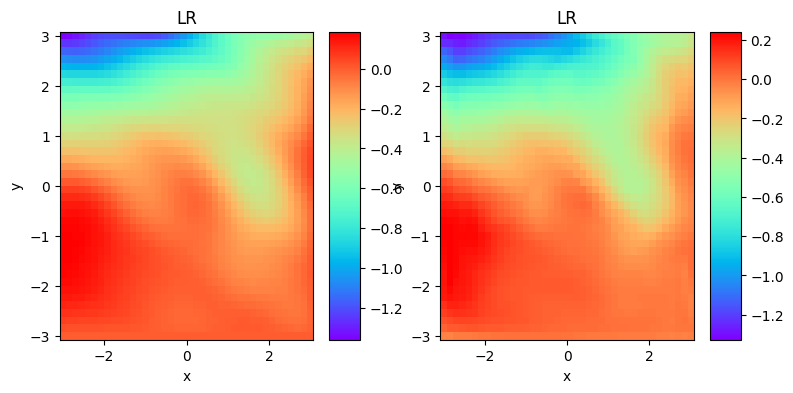

In [19]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, residual.cpu().data.numpy(), cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.03, 0.03)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, out.cpu().data.numpy()[0][0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.03, 0.03)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Upscale by 4

In [5]:
N_low = 40
N_high = 160
scale = 4
a,b,c,d = -2.5,-2.5,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [6]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c,d)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.002
ll_sigma = 0.001

In [8]:
A_high = csr_matrix(A_high)

operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [9]:
# G = ResidualLearning().to(device)
G = U_net(1,1).to(device)
# G.load_state_dict(torch.load('models/train_NN/model3/31_121/lr0.01_gamma0.1/ckpt/best_model.pth')['netG'])
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment2/Bicubic_Downsampling/models/train_NN/40_160_bicubic/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])

<All keys matched successfully>

In [15]:
# Parameters for Langevin dynamics
import time

K = 30
s = 0.0004

x = torch.tensor(w_low).to(torch.float32).to(device)
z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high)).reshape(N_high,N_high)
z = z.clone().detach().requires_grad_(True)

start_time = time.time()
for i in range(K):
    # Grad log-likelihood
    downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
    x_hat = downscaled + G(x.reshape(1,1,N_low,N_low)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high]).to(device)
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    # chains_evolution.append(z.cpu().data.numpy())  

end_time = time.time()
print(end_time-start_time) 

0.07390832901000977


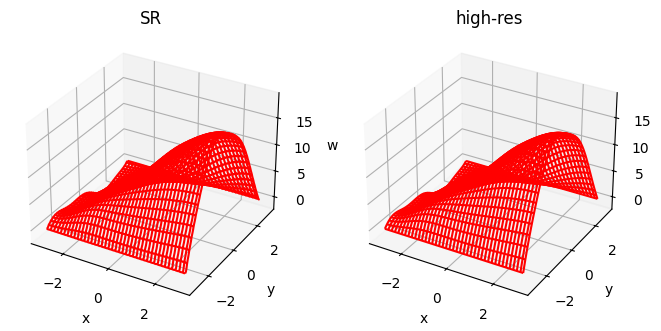

In [16]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [17]:
error1 = abs(w_high - z.cpu().data.numpy())
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.0367968344444066
